# Learn to Play Tic-toc-toe

The goal of this assignment is to make your RL agent learn to play tic-toc-toe using tabular RL methods and compare the methods in the process.

## Task 1: Describe your MDP (2 marks)

Design your MDP for this problem.
- Mention what are your states and how are the states represented.
- Mention the dynamics of your reward function

# Markov Decision Process (MDP) for Tic Tac Toe

## 1. Problem Definition

Tic Tac Toe is a two-player game where players take turns marking a 3x3 grid with their respective symbols ('X' and 'O'). The goal is to get three of their symbols in a row, column, or diagonal.

## 2. Components of the MDP

### States
- A state in the Tic Tac Toe game represents the configuration of the board. Each state can be described as a list of 9 integers, where:
  - `0` represents an empty cell.
  - `1` represents a cell occupied by the agent.
  - `2` represents a cell occupied by the opponent.
  
  The state can be represented as a string of length 9, e.g., `"100000000"`.

### Actions
- Actions represent the possible moves a player can make in the game. In Tic Tac Toe, an action corresponds to placing a mark in one of the 9 empty cells.

### Transition Dynamics
- The transition dynamics describe how the state of the game changes after an action is taken. When a player takes an action (i.e., places a mark on the board):
  - The board updates with the new mark.
  - The game checks for a winner or a draw.
  - The current player changes to the other player if the game is not yet over.

### Rewards
- Rewards are given based on the outcome of the game:
  - `+1` for a win.
  - `-1` for a loss.
  - `0` for a draw or if the game is still ongoing.

### Terminal States
- Terminal states are those where the game has ended, either due to a win, a loss, or a draw.

## 3. Example MDP Formulation

### States
- Example: `"101020020"` (Agent `X` has placed marks in positions 0, 2, and 5; Opponent `O` has placed marks in positions 1, 3, and 7).

### Actions
- Example: `4` (Placing a mark in the center position).

### Transition Function
- Given a state and an action, the transition function determines the next state by placing the mark in the chosen position and updating the current player.

### Reward Function
- Example:
  - If the agent wins after the action: `+1`
  - If the opponent wins after the action: `-1`
  - If the game is a draw or ongoing: `0`


## Task 2: Implement your agent using Monte Carlo (4 marks)

Given any situation on the board, your agent should take an action. After your agent takes an action, the opponent (which can also be another instance of one of your agents) also takes an action. Your agent learns based on what happened.

For a cleaner implementation, you may consider having an abstract class to define the framework and implement specific RL methods in subclasses.

In this task, your agent should learn using Monte-Carlo method.

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

class TicTacToe:
    def __init__(self):
        self.reset()

    def reset(self):
        self.board = [0] * 9  # 0 = empty, 1 = agent, 2 = opponent
        self.current_player = 1  # 1 for agent, 2 for opponent
        self.done = False
        self.winner = None


    def available_actions(self):
        return [i for i, x in enumerate(self.board) if x == 0]

    def take_action(self, action):
        if self.done or self.board[action] != 0:
            return

        self.board[action] = self.current_player
        if self.check_winner(self.current_player):
            self.done = True
            self.winner = self.current_player
        elif not self.available_actions():
            self.done = True  # Draw
        else:
            self.current_player = 2 if self.current_player == 1 else 1

    def check_winner(self, player):
        wins = [
            [0, 1, 2], [3, 4, 5], [6, 7, 8],  # rows
            [0, 3, 6], [1, 4, 7], [2, 5, 8],  # columns
            [0, 4, 8], [2, 4, 6]  # diagonals
        ]
        for win in wins:
            if all(self.board[i] == player for i in win):
                return True
        return False

    def get_state(self):
        return ''.join(map(str, self.board))

    def get_winner(self):
        return self.winner

    def is_done(self):
        return self.done

    def is_winning_move(self, action, player):
        """Check if placing `player` at `action` results in a win."""
        temp_board = self.board.copy()
        temp_board[action] = player
        temp_env = TicTacToe()
        temp_env.board = temp_board
        return temp_env.check_winner(player)

class MonteCarloAgent:
    def __init__(self, player_id, epsilon=0.1,gamma=1):
        self.player_id = player_id
        self.epsilon = epsilon
        self.q_values = defaultdict(lambda: np.zeros(9))
        self.returns = defaultdict(lambda: defaultdict(list))
        self.episode_memory = []
        self.gamma = gamma

    def choose_action(self, state, available_actions):
        if np.random.rand() < self.epsilon:
            return np.random.choice(available_actions)
        else:
            q_values = self.q_values[state]
            max_value = np.max(q_values[available_actions])
            best_actions = [a for a in available_actions if q_values[a] == max_value]
            return np.random.choice(best_actions)

    def update_q_values(self, episode):
        G = 0
        for state, action, reward in reversed(episode):
            G = self.gamma * reward + G
            if (state, action) not in [(s, a) for s, a, _ in episode[:-1]]:
                self.returns[state][action].append(G)
                self.q_values[state][action] = np.random.random() #np.mean(self.returns[state][action])

    def play_episode(self, opponent):
        env = TicTacToe()
        self.episode_memory = []
        while not env.is_done():
            state = env.get_state()
            available_actions = env.available_actions()
            if env.current_player == self.player_id:
                action = self.choose_action(state, available_actions)
            else:
                action = opponent.choose_action(state, available_actions)
            env.take_action(action)
            reward = 1 if env.get_winner() == self.player_id else -1 if env.get_winner() == (3 - self.player_id) else 0
            self.episode_memory.append((state, action, reward))
        self.update_q_values(self.episode_memory)
        return env.get_winner()

class RandomPlayer:
    def __init__(self, player_id):
        self.player_id = player_id

    def choose_action(self, state, available_actions):
        return np.random.choice(available_actions)

def train_agents(num_episodes):
    agent1 = MonteCarloAgent(player_id=1)
    agent2 = MonteCarloAgent(player_id=2)
    win_counts = {1: 0, 2: 0, 0: 0}
    episode_results = []

    for episode in range(num_episodes):
        winner = agent1.play_episode(agent2)
        if winner:
            win_counts[winner] += 1
        else:
            win_counts[0] += 1
        episode_results.append(win_counts.copy())

        # if episode % 1000 == 0:
        #     print(f'Episode {episode}: Wins - Agent 1: {win_counts[1]}, Agent 2: {win_counts[2]}, Draws: {win_counts[0]}')

    return agent1, episode_results

def play_and_display(agent, random_player, num_games=5):
    win_counts = {1: 0, 2: 0, 0: 0}
    for game in range(num_games):
        env = TicTacToe()
        while not env.is_done():
            state = env.get_state()
            available_actions = env.available_actions()
            if env.current_player == agent.player_id:
                action = agent.choose_action(state, available_actions)
            else:
                action = random_player.choose_action(state, available_actions)
            env.take_action(action)

        winner = env.get_winner()
        result = "Draw" if winner is None else "Agent Win" if winner == agent.player_id else "Random Player Win"
        win_counts[winner if winner else 0] += 1

        print(f"Game {game + 1}: {result}")
        print_board(np.array(env.board).reshape(3, 3))
        print("")

    print(f"Final Results: Wins - Agent: {win_counts[1]}, Random Player: {win_counts[2]}, Draws: {win_counts[0]}")

def print_board(board):
    symbols = {0: ".", 1: "X", 2: "O"}
    print("\n".join(" ".join(symbols[cell] for cell in row) for row in board))


In [46]:
# Train Monte Carlo agents
num_train_episodes = 10000
trained_agent, training_results = train_agents(num_train_episodes)

# Initialize the random player
random_player = RandomPlayer(player_id=2)

# Play games and display results
print("Some game played by agents: ")
num_test_games = 10
play_and_display(trained_agent, random_player, num_test_games)


Some game played by agents: 
Game 1: Agent Win
O X X
. O X
O . X

Game 2: Agent Win
O . O
X X X
O . X

Game 3: Agent Win
. . .
X X X
O . O

Game 4: Agent Win
X X X
. O O
O X .

Game 5: Agent Win
. . O
O . .
X X X

Game 6: Agent Win
X X X
. O O
X O .

Game 7: Agent Win
X X X
. . O
O O X

Game 8: Draw
X X O
O X X
X O O

Game 9: Agent Win
. . X
O X .
X O .

Game 10: Agent Win
. O .
O . .
X X X

Final Results: Wins - Agent: 9, Random Player: 0, Draws: 1


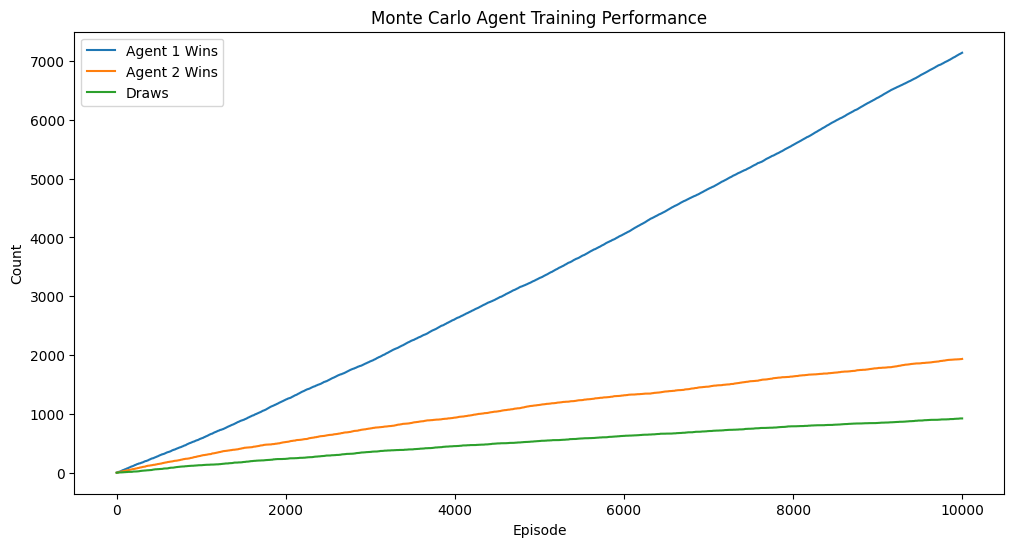

In [48]:
# Convert training results to arrays for plotting
episodes = list(range(num_train_episodes))
wins_agent1 = [result[1] for result in training_results]
wins_agent2 = [result[2] for result in training_results]
draws = [result[0] for result in training_results]

plt.figure(figsize=(12, 6))
plt.plot(episodes, wins_agent1, label='Agent 1 Wins')
plt.plot(episodes, wins_agent2, label='Agent 2 Wins')
plt.plot(episodes, draws, label='Draws')
plt.xlabel('Episode')
plt.ylabel('Count')
plt.title('Monte Carlo Agent Training Performance')
plt.legend()
plt.show()


## Task 3: Implement your agent using Q-Learning (4 marks)

Implement same as Task 2 using Q-learning.

In [49]:
class QLearningAgent:
    def __init__(self, player_id, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.player_id = player_id
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_values = defaultdict(lambda: np.zeros(9))

    def choose_action(self, state, available_actions):
        if np.random.rand() < self.epsilon:
            return np.random.choice(available_actions)
        else:
            q_values = self.q_values[state]
            max_value = np.max(q_values[available_actions])
            best_actions = [a for a in available_actions if q_values[a] == max_value]
            return np.random.choice(best_actions)

    def update_q_values(self, state, action, reward, next_state, done):
        best_next_action = np.max(self.q_values[next_state]) if not done else 0
        td_target = reward + self.gamma * best_next_action
        td_error = td_target - self.q_values[state][action]
        self.q_values[state][action] += self.alpha * td_error

    def play_episode(self, opponent):
        env = TicTacToe()
        while not env.is_done():
            state = env.get_state()
            available_actions = env.available_actions()
            if env.current_player == self.player_id:
                action = self.choose_action(state, available_actions)
            else:
                action = opponent.choose_action(state, available_actions)
            env.take_action(action)
            reward = 1 if env.get_winner() == self.player_id else -1 if env.get_winner() == (3 - self.player_id) else 0
            next_state = env.get_state()
            self.update_q_values(state, action, reward, next_state, env.is_done())

        return env.get_winner()

def train_agents(num_episodes):
    agent1 = QLearningAgent(player_id=1)
    agent2 = QLearningAgent(player_id=2)
    win_counts = {1: 0, 2: 0, 0: 0}
    episode_results = []

    for episode in range(num_episodes):
        winner = agent1.play_episode(agent2)
        if winner:
            win_counts[winner] += 1
        else:
            win_counts[0] += 1
        episode_results.append(win_counts.copy())

        # if episode % 1000 == 0:
        #     print(f'Episode {episode}: Wins - Agent 1: {win_counts[1]}, Agent 2: {win_counts[2]}, Draws: {win_counts[0]}')

    return agent1, episode_results


In [50]:
# Train Q-Learning agents
num_train_episodes = 1000
trained_agent, training_results = train_agents(num_train_episodes)

In [51]:
# Initialize the random player
random_player = RandomPlayer(player_id=2)

# Play games and display results

print("Some game played by agents: ")
num_test_games = 20
play_and_display(trained_agent, random_player, num_test_games)

Some game played by agents: 
Game 1: Agent Win
O X O
O O X
X X X

Game 2: Agent Win
. X .
. X .
O X O

Game 3: Random Player Win
O . .
O X X
O X .

Game 4: Agent Win
. X O
. X .
O X .

Game 5: Random Player Win
O O O
. X X
X X O

Game 6: Agent Win
. X .
O X .
. X O

Game 7: Draw
X O O
O X X
X X O

Game 8: Agent Win
. X O
. X .
O X .

Game 9: Agent Win
. X .
O X .
. X O

Game 10: Agent Win
. X .
. X O
O X .

Game 11: Agent Win
. X .
O X .
O X .

Game 12: Agent Win
. X .
O X .
O X .

Game 13: Agent Win
. O X
. X O
X X O

Game 14: Random Player Win
O O X
O X X
O X .

Game 15: Agent Win
O O X
O . X
. X X

Game 16: Agent Win
. O X
X O X
O . X

Game 17: Agent Win
O O X
X X X
O X O

Game 18: Agent Win
X O O
X O X
X X O

Game 19: Agent Win
. O .
X X X
O X O

Game 20: Agent Win
. . X
O X O
X X O

Final Results: Wins - Agent: 16, Random Player: 3, Draws: 1


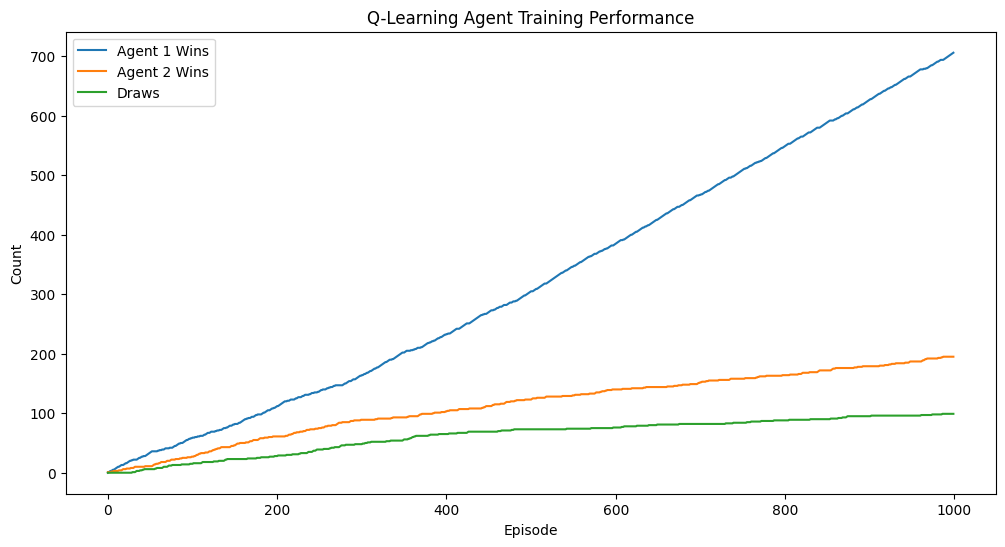

In [52]:
# Convert training results to arrays for plotting
episodes = list(range(num_train_episodes))
wins_agent1 = [result[1] for result in training_results]
wins_agent2 = [result[2] for result in training_results]
draws = [result[0] for result in training_results]

plt.figure(figsize=(12, 6))
plt.plot(episodes, wins_agent1, label='Agent 1 Wins')
plt.plot(episodes, wins_agent2, label='Agent 2 Wins')
plt.plot(episodes, draws, label='Draws')
plt.xlabel('Episode')
plt.ylabel('Count')
plt.title('Q-Learning Agent Training Performance')
plt.legend()
plt.show()

## Task 4: Compare the two methods (4 marks)

Use any good implementation of the minimax algorithm typically used for the tic-toc-toe game as the opponent. Note that the algorithm is optimal, so it may never lose. Modify that algorithm to take random available actions $\epsilon$ fraction of the times so that your agent can learn. Choose a suitable $\epsilon$, too small may not be a good idea.

Compare how fast your Monte-Carlo and Q-Learning implementations learn against the modified minimax algorithm. Use suitable plots.

In [53]:
class MinimaxPlayer:
    def __init__(self, player_id, epsilon=0.1):
        self.player_id = player_id
        self.epsilon = epsilon

    def choose_action(self, state, available_actions):
        if np.random.rand() < self.epsilon:
            return np.random.choice(available_actions)
        else:
            return self.minimax(state, available_actions)[1]

    def minimax(self, state, available_actions):
        best_action = None
        if self.check_winner(state) == self.player_id:
            return (1, None)
        elif self.check_winner(state) == (3 - self.player_id):
            return (-1, None)
        elif not available_actions:
            return (0, None)

        best_value = -np.inf if self.player_id == 1 else np.inf

        for action in available_actions:
            next_state = self.simulate(state, action)
            value = self.minimax_value(next_state, 2 if self.player_id == 1 else 1)
            if self.player_id == 1:
                if value > best_value:
                    best_value = value
                    best_action = action
            else:
                if value < best_value:
                    best_value = value
                    best_action = action

        return (best_value, best_action)

    def minimax_value(self, state, player):
        available_actions = [i for i, x in enumerate(state) if x == '0']
        if self.check_winner(state) == player:
            return 1
        elif self.check_winner(state) == (3 - player):
            return -1
        elif not available_actions:
            return 0

        best_value = -np.inf if player == 1 else np.inf
        for action in available_actions:
            next_state = self.simulate(state, action)
            value = self.minimax_value(next_state, 2 if player == 1 else 1)
            if player == 1:
                best_value = max(best_value, value)
            else:
                best_value = min(best_value, value)

        return best_value

    def simulate(self, state, action):
        new_board = list(state)
        new_board[action] = str(self.player_id)
        return ''.join(new_board)

    def check_winner(self, state):
        board = [int(x) for x in state]
        wins = [
            [0, 1, 2], [3, 4, 5], [6, 7, 8],  # rows
            [0, 3, 6], [1, 4, 7], [2, 5, 8],  # columns
            [0, 4, 8], [2, 4, 6]  # diagonals
        ]
        for win in wins:
            if all(board[i] == self.player_id for i in win):
                return self.player_id
        return None

def train_against_minimax(agent, num_episodes, epsilon_minimax):
    minimax_player = MinimaxPlayer(player_id=2, epsilon=epsilon_minimax)
    win_counts = {1: 0, 2: 0, 0: 0}
    episode_results = []

    for episode in range(num_episodes):
        winner = agent.play_episode(minimax_player)
        if winner:
            win_counts[winner] += 1
        else:
            win_counts[0] += 1
        episode_results.append(win_counts.copy())

        if episode % 100 == 0:
            print(f'Episode {episode}: Wins - Agent: {win_counts[1]}, Minimax: {win_counts[2]}, Draws: {win_counts[0]}')

    return episode_results


Train Monte Carlo agent against minimax
Episode 0: Wins - Agent: 1, Minimax: 0, Draws: 0
Episode 100: Wins - Agent: 51, Minimax: 35, Draws: 15
Episode 200: Wins - Agent: 110, Minimax: 66, Draws: 25
Episode 300: Wins - Agent: 174, Minimax: 93, Draws: 34
Episode 400: Wins - Agent: 239, Minimax: 113, Draws: 49
Episode 500: Wins - Agent: 301, Minimax: 143, Draws: 57
Episode 600: Wins - Agent: 364, Minimax: 167, Draws: 70
Episode 700: Wins - Agent: 427, Minimax: 193, Draws: 81
Episode 800: Wins - Agent: 498, Minimax: 217, Draws: 86
Episode 900: Wins - Agent: 559, Minimax: 248, Draws: 94
Train Q-Learning agent against minimax
Episode 0: Wins - Agent: 1, Minimax: 0, Draws: 0
Episode 100: Wins - Agent: 65, Minimax: 30, Draws: 6
Episode 200: Wins - Agent: 123, Minimax: 65, Draws: 13
Episode 300: Wins - Agent: 190, Minimax: 93, Draws: 18
Episode 400: Wins - Agent: 267, Minimax: 110, Draws: 24
Episode 500: Wins - Agent: 346, Minimax: 130, Draws: 25
Episode 600: Wins - Agent: 431, Minimax: 143, Dr

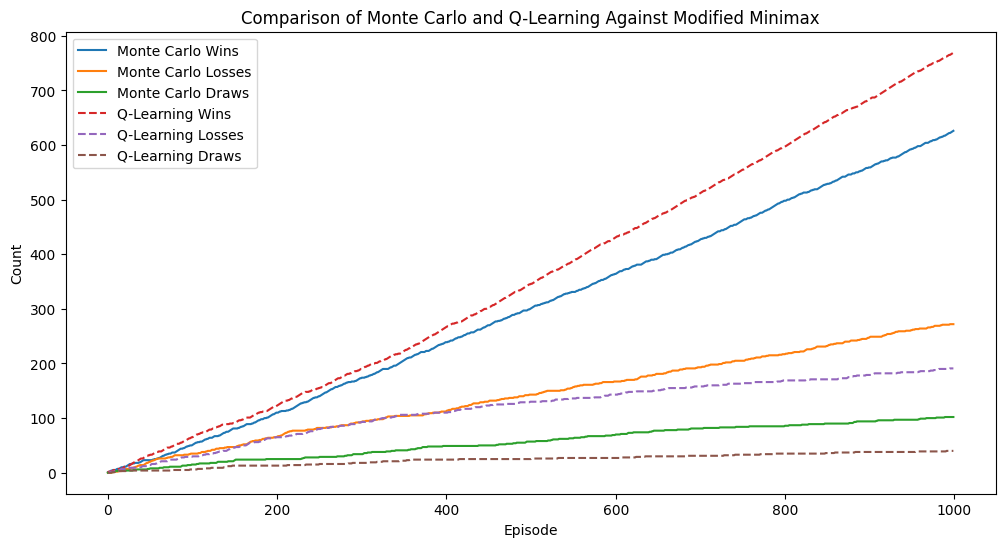

In [54]:
# Initialize agents
num_train_episodes = 1000
epsilon_minimax = 0.4  # Choose an epsilon value for the minimax agent

# Train Monte Carlo agent against minimax
print("Train Monte Carlo agent against minimax")
monte_carlo_agent = MonteCarloAgent(player_id=1)
monte_carlo_results = train_against_minimax(monte_carlo_agent, num_train_episodes, epsilon_minimax)

# Train Q-Learning agent against minimax
print("Train Q-Learning agent against minimax")
q_learning_agent = QLearningAgent(player_id=1)
q_learning_results = train_against_minimax(q_learning_agent, num_train_episodes, epsilon_minimax)

# Convert results to arrays for plotting
episodes = list(range(num_train_episodes))
monte_carlo_wins = [result[1] for result in monte_carlo_results]
monte_carlo_losses = [result[2] for result in monte_carlo_results]
monte_carlo_draws = [result[0] for result in monte_carlo_results]

q_learning_wins = [result[1] for result in q_learning_results]
q_learning_losses = [result[2] for result in q_learning_results]
q_learning_draws = [result[0] for result in q_learning_results]

plt.figure(figsize=(12, 6))
plt.plot(episodes, monte_carlo_wins, label='Monte Carlo Wins')
plt.plot(episodes, monte_carlo_losses, label='Monte Carlo Losses')
plt.plot(episodes, monte_carlo_draws, label='Monte Carlo Draws')

plt.plot(episodes, q_learning_wins, label='Q-Learning Wins', linestyle='--')
plt.plot(episodes, q_learning_losses, label='Q-Learning Losses', linestyle='--')
plt.plot(episodes, q_learning_draws, label='Q-Learning Draws', linestyle='--')

plt.xlabel('Episode')
plt.ylabel('Count')
plt.title('Comparison of Monte Carlo and Q-Learning Against Modified Minimax')
plt.legend()
plt.show()


In [55]:
def play_game(agent1, agent2, agent1_name, agent2_name):
    env = TicTacToe()
    while not env.is_done():
        state = env.get_state()
        available_actions = env.available_actions()
        if env.current_player == agent1.player_id:
            action = agent1.choose_action(state, available_actions)
        else:
            action = agent2.choose_action(state, available_actions)
        env.take_action(action)

    winner = env.get_winner()
    if winner:
        return f"{agent1_name} wins" if winner == agent1.player_id else f"{agent2_name} wins"
    else:
        return "Draw"

# Initialize agents
random_agent = RandomPlayer(player_id=2)


# For demonstration, manually set Q-values or load trained Q-values
# Example (replace with actual trained values):
# monte_carlo_agent.q_values = load_monte_carlo_q_values()
# q_learning_agent.q_values = load_q_learning_q_values()

# Play games
num_games = 1000
monte_carlo_results = {'Monte Carlo Agent wins': 0, 'Random Agent wins': 0, 'Draws': 0}
q_learning_results = {'Q-Learning Agent wins': 0, 'Random Agent wins': 0, 'Draws': 0}


# Lists to track cumulative results for plotting
monte_carlo_win_counts = []
monte_carlo_draw_counts = []
monte_carlo_loss_counts = []

q_learning_win_counts = []
q_learning_draw_counts = []
q_learning_loss_counts = []

for game in range(num_games):
    result_mc = play_game(monte_carlo_agent, random_agent, 'Monte Carlo Agent', 'Random Agent')
    result_ql = play_game(q_learning_agent, random_agent, 'Q-Learning Agent', 'Random Agent')

    # Update counts
    if result_mc == 'Monte Carlo Agent wins':
        monte_carlo_results['Monte Carlo Agent wins'] += 1
    elif result_mc == 'Random Agent wins':
        monte_carlo_results['Random Agent wins'] += 1
    else:
        monte_carlo_results['Draws'] += 1

    if result_ql == 'Q-Learning Agent wins':
        q_learning_results['Q-Learning Agent wins'] += 1
    elif result_ql == 'Random Agent wins':
        q_learning_results['Random Agent wins'] += 1
    else:
        q_learning_results['Draws'] += 1

    # Track cumulative results for plotting
    monte_carlo_win_counts.append(monte_carlo_results['Monte Carlo Agent wins'])
    monte_carlo_draw_counts.append(monte_carlo_results['Draws'])
    monte_carlo_loss_counts.append(monte_carlo_results['Random Agent wins'])

    q_learning_win_counts.append(q_learning_results['Q-Learning Agent wins'])
    q_learning_draw_counts.append(q_learning_results['Draws'])
    q_learning_loss_counts.append(q_learning_results['Random Agent wins'])


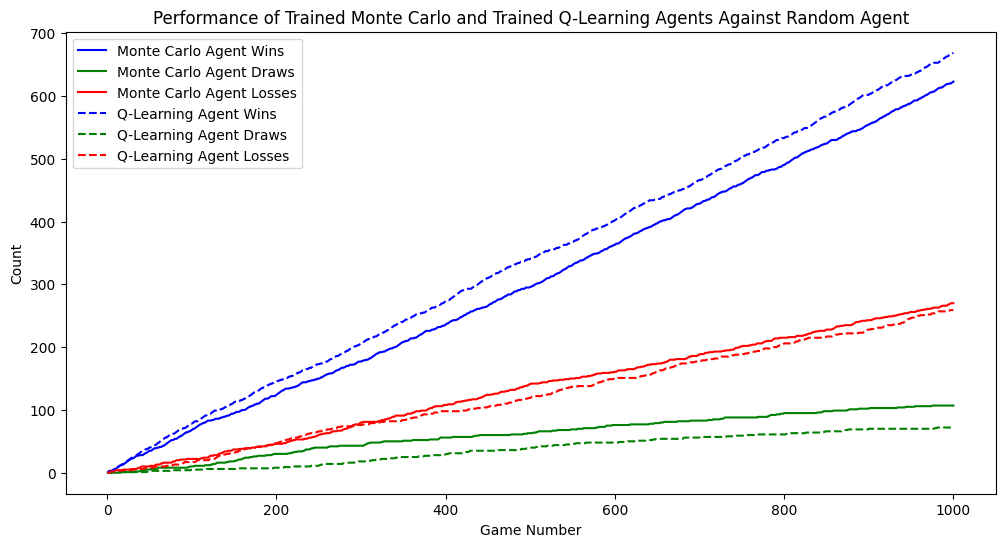

In [56]:
# Plotting
episodes = list(range(1,num_games+1))

plt.figure(figsize=(12, 6))

plt.plot(episodes, monte_carlo_win_counts, label='Monte Carlo Agent Wins', color='blue')
plt.plot(episodes, monte_carlo_draw_counts, label='Monte Carlo Agent Draws', color='green')
plt.plot(episodes, monte_carlo_loss_counts, label='Monte Carlo Agent Losses', color='red')

plt.plot(episodes, q_learning_win_counts, label='Q-Learning Agent Wins', linestyle='--', color='blue')
plt.plot(episodes, q_learning_draw_counts, label='Q-Learning Agent Draws', linestyle='--', color='green')
plt.plot(episodes, q_learning_loss_counts, label='Q-Learning Agent Losses', linestyle='--', color='red')

plt.xlabel('Game Number')
plt.ylabel('Count')
plt.title('Performance of Trained Monte Carlo and Trained Q-Learning Agents Against Random Agent')
plt.legend()
plt.show()

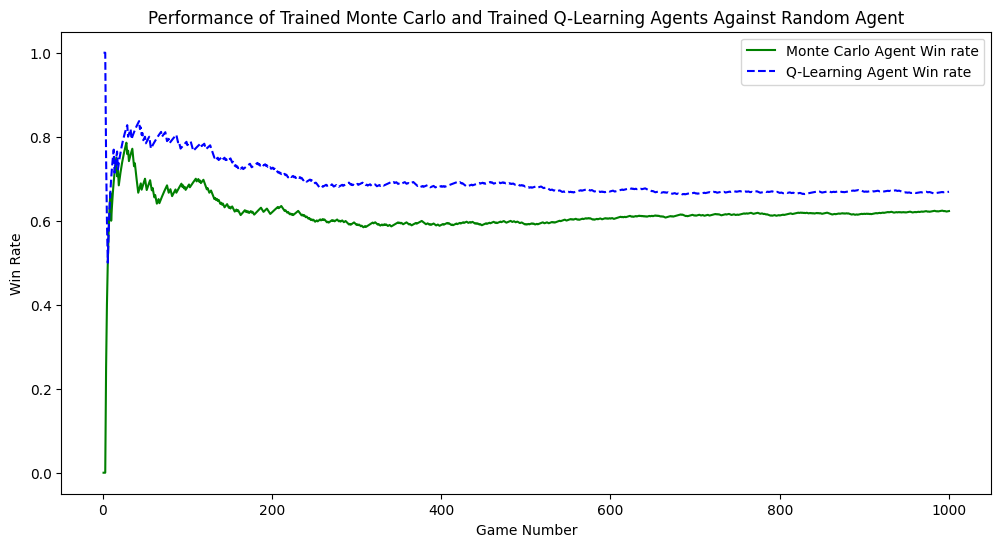

In [57]:
monte_carlo_wins_rate = [i/z for i,z in zip(monte_carlo_win_counts,episodes)]
q_learning_win_rate = [i/z for i,z in zip(q_learning_win_counts,episodes)]
plt.figure(figsize=(12, 6))

plt.plot(episodes, monte_carlo_wins_rate, label='Monte Carlo Agent Win rate', color='green')

plt.plot(episodes, q_learning_win_rate, label='Q-Learning Agent Win rate', linestyle='--', color='blue')

plt.xlabel('Game Number')
plt.ylabel('Win Rate')
plt.title('Performance of Trained Monte Carlo and Trained Q-Learning Agents Against Random Agent')
plt.legend()
plt.show()

## Task 5: Let the two agents play against each other (4 marks)

Initialize both agents in the same way and let them play against each other and learn. Evaluate whether one agent learns to win quicker than the other. Does the other agent catch up eventually? Use suitable plots.

In [58]:
def train_agents(num_episodes):
    agent1 = MonteCarloAgent(player_id=1)
    agent2 = QLearningAgent(player_id=2)

    results = {
        'Agent 1 Wins': 0,
        'Agent 2 Wins': 0,
        'Draws': 0
    }

    # Track performance for plotting
    agent1_win_counts = []
    agent2_win_counts = []
    draws_counts = []

    for episode in range(num_episodes):
        result = play_game(agent1, agent2, 'Monte Carlo Agent', 'Q-Learning Agent')

        # Update results
        if result == 'Monte Carlo Agent wins':
            results['Agent 1 Wins'] += 1
        elif result == 'Q-Learning Agent wins':
            results['Agent 2 Wins'] += 1
        else:
            results['Draws'] += 1

        # Track cumulative results
        agent1_win_counts.append(results['Agent 1 Wins'])
        agent2_win_counts.append(results['Agent 2 Wins'])
        draws_counts.append(results['Draws'])

        # No need to update Q-values for QLearningAgent since it updates during play_episode

    return agent1_win_counts, agent2_win_counts, draws_counts

# Train and plot results
num_episodes = 1000
agent1_win_counts, agent2_win_counts, draws_counts = train_agents(num_episodes)

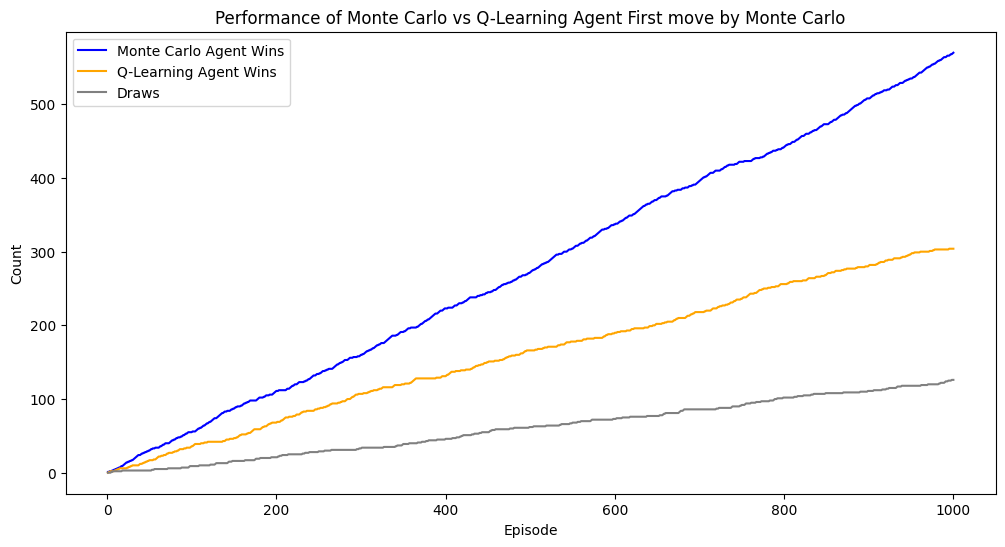

In [59]:
# Plotting
episodes = list(range(1,num_episodes+1))

plt.figure(figsize=(12, 6))

plt.plot(episodes, agent1_win_counts, label='Monte Carlo Agent Wins', color='blue')
plt.plot(episodes, agent2_win_counts, label='Q-Learning Agent Wins', color='orange')
plt.plot(episodes, draws_counts, label='Draws', color='gray')

plt.xlabel('Episode')
plt.ylabel('Count')
plt.title('Performance of Monte Carlo vs Q-Learning Agent First move by Monte Carlo')
plt.legend()
plt.show()

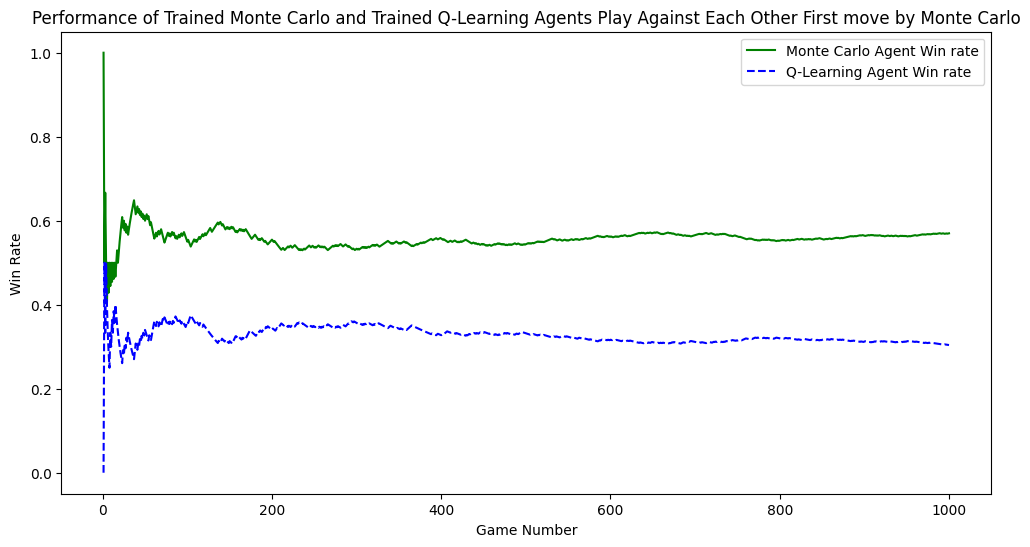

In [60]:
monte_carlo_wins_rate = [i/z for i,z in zip(agent1_win_counts,episodes)]
q_learning_win_rate = [i/z for i,z in zip(agent2_win_counts,episodes)]
plt.figure(figsize=(12, 6))

plt.plot(episodes, monte_carlo_wins_rate, label='Monte Carlo Agent Win rate', color='green')

plt.plot(episodes, q_learning_win_rate, label='Q-Learning Agent Win rate', linestyle='--', color='blue')

plt.xlabel('Game Number')
plt.ylabel('Win Rate')
plt.title('Performance of Trained Monte Carlo and Trained Q-Learning Agents Play Against Each Other First move by Monte Carlo')
plt.legend()
plt.show()

In [61]:
def train_agents(num_episodes):
    agent1 = MonteCarloAgent(player_id=1)
    agent2 = QLearningAgent(player_id=2)

    results = {
        'Agent 1 Wins': 0,
        'Agent 2 Wins': 0,
        'Draws': 0
    }

    # Track performance for plotting
    agent1_win_counts = []
    agent2_win_counts = []
    draws_counts = []

    for episode in range(num_episodes):
        result = play_game(agent2, agent1, 'Q-Learning Agent', 'Monte Carlo Agent')

        # Update results
        if result == 'Monte Carlo Agent wins':
            results['Agent 1 Wins'] += 1
        elif result == 'Q-Learning Agent wins':
            results['Agent 2 Wins'] += 1
        else:
            results['Draws'] += 1

        # Track cumulative results
        agent1_win_counts.append(results['Agent 1 Wins'])
        agent2_win_counts.append(results['Agent 2 Wins'])
        draws_counts.append(results['Draws'])

        # No need to update Q-values for QLearningAgent since it updates during play_episode

    return agent1_win_counts, agent2_win_counts, draws_counts, agent1

# Train and plot results
num_episodes = 1000
agent1_win_counts, agent2_win_counts, draws_counts, monte_carlo_trained_agent = train_agents(num_episodes)

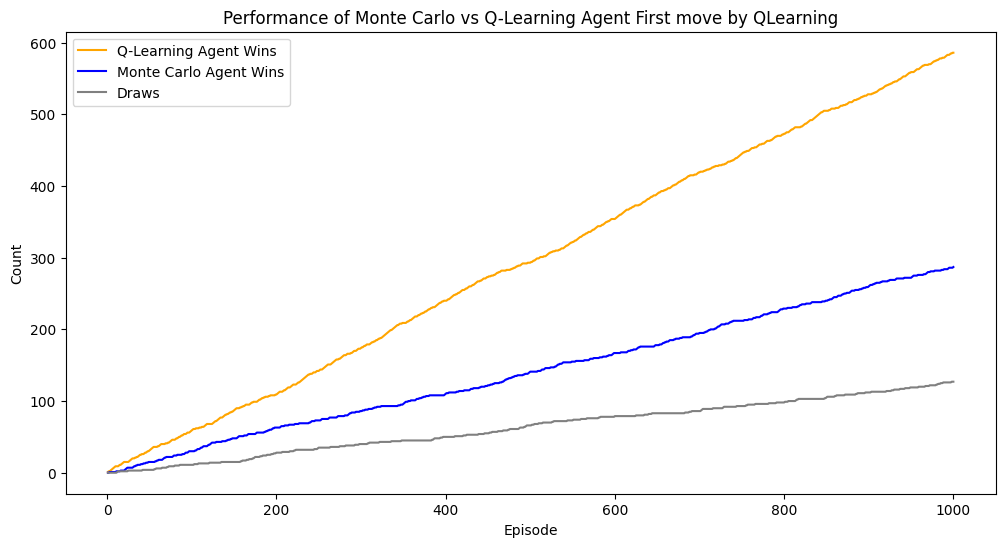

In [62]:
# Plotting
episodes = list(range(1,num_episodes+1))

plt.figure(figsize=(12, 6))

plt.plot(episodes, agent1_win_counts, label='Q-Learning Agent Wins', color='orange')
plt.plot(episodes, agent2_win_counts, label='Monte Carlo Agent Wins', color='blue')
plt.plot(episodes, draws_counts, label='Draws', color='gray')

plt.xlabel('Episode')
plt.ylabel('Count')
plt.title('Performance of Monte Carlo vs Q-Learning Agent First move by QLearning')
plt.legend()
plt.show()

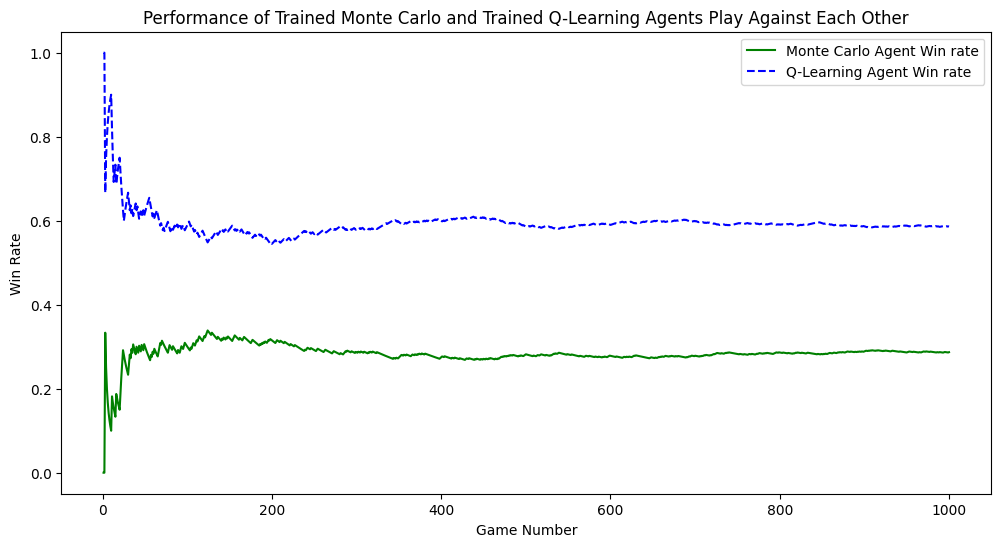

In [63]:
q_learning_win_rate = [i/z for i,z in zip(agent1_win_counts,episodes)]
monte_carlo_wins_rate= [i/z for i,z in zip(agent2_win_counts,episodes)]
plt.figure(figsize=(12, 6))

plt.plot(episodes, monte_carlo_wins_rate, label='Monte Carlo Agent Win rate', color='green')

plt.plot(episodes, q_learning_win_rate, label='Q-Learning Agent Win rate', linestyle='--', color='blue')

plt.xlabel('Game Number')
plt.ylabel('Win Rate')
plt.title('Performance of Trained Monte Carlo and Trained Q-Learning Agents Play Against Each Other')
plt.legend()
plt.show()

## Task 6: Identify winning positions (2 marks)

Once your agents have learnt optimal policies, they are good enough to force wins from certain situations of the board. Obviously, if the board is almost finished (most boxes ticked), such situations are more common. But what are the positions of the board with minimal number of moves played from which one player can force a win, no matter what the opponent does? Identify such situations using functions that your agent has learnt.

In [64]:
def print_board(board):
    symbols = {0: ".", 1: "X", 2: "O"}
    print("\n".join(" ".join(symbols[cell] for cell in row) for row in board))

def rotate_90(board):
    return [board[6], board[3], board[0], board[7], board[4], board[1], board[8], board[5], board[2]]

def get_rotations(board):
    rotations = []
    current = board
    for _ in range(4):
        current = rotate_90(current)
        rotations.append(current)
    return rotations

def mirror_horizontal(board):
    return [board[2], board[1], board[0], board[5], board[4], board[3], board[8], board[7], board[6]]

def mirror_vertical(board):
    return [board[6], board[7], board[8], board[3], board[4], board[5], board[0], board[1], board[2]]

def get_reflections(board):
    return [mirror_horizontal(board), mirror_vertical(board)]

def normalize_board(board):
    # Convert board to tuple for consistent comparison
    board = tuple(board)

    # Get all rotations and reflections of the board
    rotations = get_rotations(board)
    reflections = [board] + get_reflections(board)

    # Convert all boards to tuples
    all_boards = [tuple(rot) for rot in rotations] + [tuple(ref) for ref in reflections]

    # Find the lexicographically smallest board
    min_board = min(all_boards)
    return min_board

def remove_symmetric_positions(positions):
    normalized_boards = set()
    unique_positions = []

    for board, move in positions:
        normalized = normalize_board(board)
        if normalized not in normalized_boards:
            normalized_boards.add(normalized)
            unique_positions.append((board, move))

    return unique_positions

def find_winning_positions(agent, num_simulations=1000):
    winning_positions = []

    for _ in range(num_simulations):
        env = TicTacToe()
        num_moves = np.random.randint(1, 6)  # Simulate between 1 to 5 moves
        moves = np.random.choice(env.available_actions(), size=num_moves, replace=False)

        for move in moves:
            env.take_action(move)

        available_actions = env.available_actions()
        for action in available_actions:
            if env.is_winning_move(action, agent.player_id):
                board_before_move = np.array(env.board).copy()
                winning_positions.append((board_before_move, action))

    # Remove symmetric and mirror-reflective positions
    winning_positions = remove_symmetric_positions(winning_positions)

    return winning_positions


In [65]:
winning_positions = find_winning_positions(monte_carlo_trained_agent, num_simulations=1000)
# Print winning positions
print("Our agent is playing as 'X' ")
print("Winning Positions and Moves:")
for board, move in winning_positions:
    move = [move//3,move%3]
    print(f"Move at index {move}:")
    print_board(np.array(board).reshape(3, 3))
    print("")

print("Total boards and one move win explored by agent : ",len(winning_positions))

Our agent is playing as 'X' 
Winning Positions and Moves:
Move at index [1, 2]:
O . .
X X .
. . .

Move at index [2, 0]:
. O O
X . .
. X X

Move at index [0, 0]:
. . X
. X .
X O O

Move at index [0, 2]:
O . .
. . X
. . X

Move at index [0, 0]:
. . .
. X .
. O X

Move at index [0, 1]:
O . .
. X O
. X .

Move at index [1, 0]:
X O .
. O .
X . .

Move at index [2, 2]:
. O X
. . X
. . .

Move at index [0, 2]:
. . .
. X O
X O .

Move at index [0, 0]:
. X X
O O .
. . .

Move at index [0, 0]:
. . .
O X .
O X X

Move at index [1, 1]:
O X .
. . O
. X .

Move at index [2, 1]:
. X .
. X .
. . O

Move at index [0, 1]:
O . .
O X .
. X .

Move at index [0, 2]:
X X .
X . O
O . .

Move at index [2, 2]:
O X X
. . X
O . .

Move at index [0, 2]:
X X .
. . O
. X O

Move at index [0, 1]:
X . X
. . .
O X O

Move at index [0, 2]:
. . .
O X .
X . O

Move at index [1, 0]:
X . .
. . .
X . O

Move at index [0, 0]:
. . O
X . .
X O X

Move at index [2, 0]:
O . O
. . .
. X X

Move at index [2, 0]:
. . O
. O .
. X X
